In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import helpers

from PIL import Image, ImageFile
from timeit import default_timer as timer
from pathlib import Path
from torchvision.transforms import v2
from torchvision import datasets
from torch.utils.data import DataLoader
from model_vig import vig_ti_224_gelu
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from helpers import plot_loss_curves


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

train_dir = Path("./data/eksperimen-3/train/")
test_dir = Path("./data/eksperimen-3/test/")

torch.cuda.empty_cache()

train_preprocess = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((224, 224)),
        v2.RandomErasing(p=0.25),
        v2.RandAugment(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_preprpocess = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((224, 224)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_dataset = datasets.ImageFolder(str(train_dir), transform=train_preprocess)
test_dataset = datasets.ImageFolder(str(test_dir), transform=test_preprpocess)
class_names = train_dataset.classes

print(f"Total train image: {len(train_dataset)}")
print(f"Total test image: {len(test_dataset)}")
print(f"Classes/label: {class_names}")

NUM_WORKERS = 4
BATCH_SIZE = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
model = vig_ti_224_gelu(num_classes=len(class_names)).to(device)

LEARNING_RATE = 0.002
NUM_EPOCHS = 50

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

num_training_steps = NUM_EPOCHS * len(train_dataloader)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    T_max=num_training_steps,
)

cuda
Total train image: 1280
Total test image: 500
Classes/label: ['downdog', 'goddess', 'plank', 'tree', 'warrior2']
dpr [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
num_knn [9, 9, 10, 11, 12, 13, 13, 14, 15, 16, 17, 18]


In [2]:
import torch.utils.data


def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    progress_bar: tqdm | None = None,
) -> Tuple[float, float]:
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        lr_scheduler.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        if progress_bar:
            progress_bar.update(1)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [3]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device,
    progress_bar: tqdm | None = None,
) -> Tuple[float, float]:
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

            if progress_bar:
                progress_bar.update(1)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [4]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
    use_progress_bar: bool = False,
) -> Dict[str, List]:
    # Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    if use_progress_bar:
        progress_bar = tqdm(
            total=len(train_dataloader) + len(test_dataloader), desc="Processing Batch"
        )

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs), desc="Processing Epoch"):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            progress_bar=progress_bar if use_progress_bar else None,
        )
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device,
            progress_bar=progress_bar if use_progress_bar else None,
        )

        print(
            f"Epoch: {epoch+1} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Train acc: {train_acc*100:.2f}% | Test acc: {test_acc*100:.2f}% | LR: {lr_scheduler.get_last_lr()}"
        )
        progress_bar.reset()
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results


In [5]:
print(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
Image.LOAD_TRUNCATED_IMAGES = True
ImageFile.LOAD_TRUNCATED_IMAGES = True


# Start the timer
start_time = timer()

# Setup training and save the results
results = train(
    model=model.to(device),
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    device=torch.device(device),
    use_progress_bar=True,
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


cuda


Processing Batch:   0%|          | 0/14 [00:00<?, ?it/s]

Processing Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.95933 | Test loss: 92.28232 | Train acc: 23.12% | Test acc: 19.53% | LR: [0.0019980267284282717]
Epoch: 2 | Train loss: 1.71228 | Test loss: 5.63556 | Train acc: 22.27% | Test acc: 20.00% | LR: [0.0019921147013144784]
Epoch: 3 | Train loss: 1.68502 | Test loss: 1.75921 | Train acc: 20.23% | Test acc: 24.76% | LR: [0.001982287250728689]
Epoch: 4 | Train loss: 1.62041 | Test loss: 1.68497 | Train acc: 22.50% | Test acc: 24.08% | LR: [0.0019685831611286303]
Epoch: 5 | Train loss: 1.63739 | Test loss: 1.61190 | Train acc: 23.12% | Test acc: 25.52% | LR: [0.0019510565162951525]
Epoch: 6 | Train loss: 1.62336 | Test loss: 1.60950 | Train acc: 25.70% | Test acc: 26.31% | LR: [0.0019297764858882498]
Epoch: 7 | Train loss: 1.61957 | Test loss: 1.60370 | Train acc: 24.38% | Test acc: 26.68% | LR: [0.0019048270524660179]
Epoch: 8 | Train loss: 1.61883 | Test loss: 1.67513 | Train acc: 26.17% | Test acc: 23.61% | LR: [0.0018763066800438618]
Epoch: 9 | Train loss: 1.61191 |

In [6]:
import pickle
import json

with open("./results/eksperimen_3_vig_results.pkl", "wb") as f:
    pickle.dump(results, f)


with open("./results/eksperimen_3_vig_results.pkl", "rb") as f:
    loaded_dict = pickle.load(f)

print(json.dumps(results, indent=4))


{
    "train_loss": [
        1.9593315362930297,
        1.7122798562049866,
        1.6850175738334656,
        1.6204118490219117,
        1.6373928666114808,
        1.6233588576316833,
        1.6195682048797608,
        1.618830931186676,
        1.6119147300720216,
        1.597506034374237,
        1.572430467605591,
        1.5801167488098145,
        1.587933099269867,
        1.5716553926467896,
        1.54236181974411,
        1.5125667929649353,
        1.4725034475326537,
        1.483973467350006,
        1.4434682130813599,
        1.3842225909233092,
        1.376462459564209,
        1.3446411728858947,
        1.2940346121788024,
        1.25243479013443,
        1.2177530765533446,
        1.2055400729179382,
        1.144431734085083,
        1.1516472101211548,
        1.1188663721084595,
        1.0769456565380096,
        1.0716235399246217,
        1.0047172605991364,
        1.005381029844284,
        0.9814809560775757,
        0.9307366251945496,
        0.

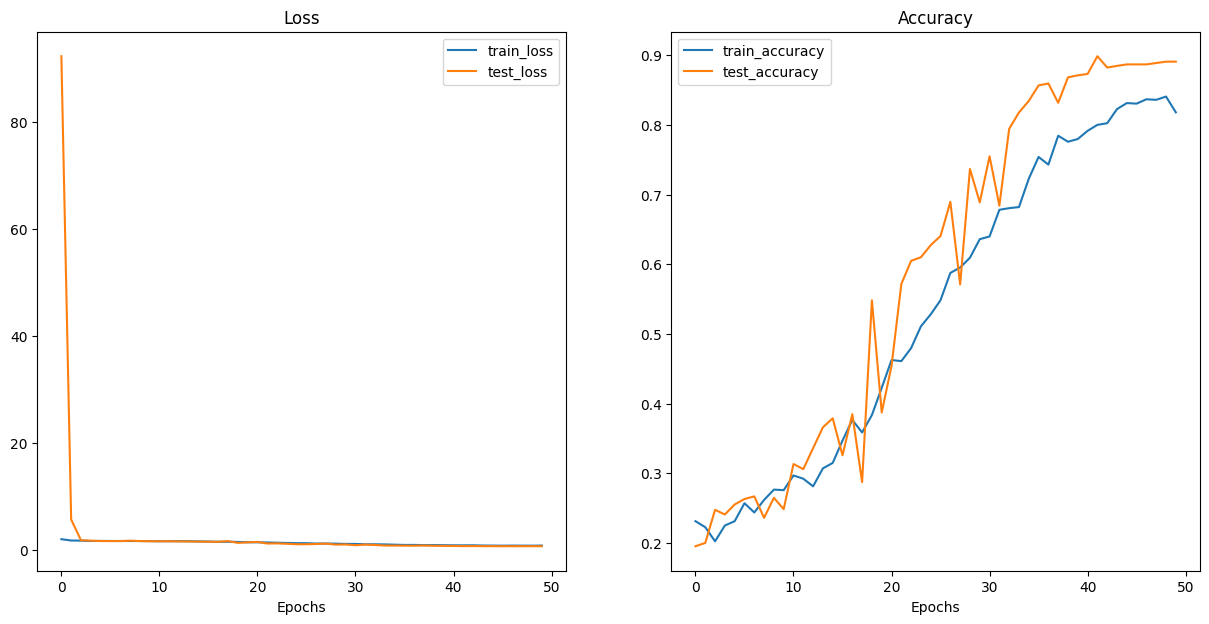

In [7]:
# Plot the loss curves of our model
plot_loss_curves(results)


In [8]:
save_dir = Path("./models/eksperimen_3_vig.pth")

torch.save(
    {
        "epoch": NUM_EPOCHS,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    },
    save_dir,
)


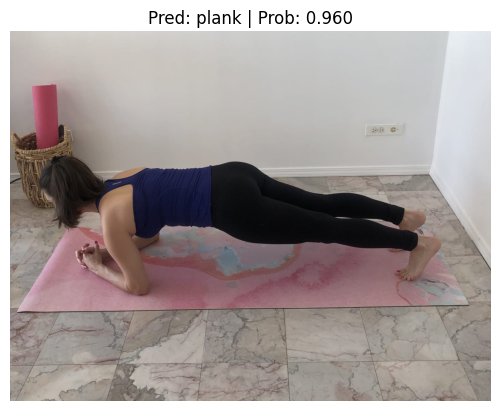

In [9]:
# Setup path to data folder
custom_image_path = Path("./data/custom-data/elbowplank-911ae2.jpg")

# Predict on custom image
helpers.pred_and_plot_image(
    model=model, image_path=str(custom_image_path), class_names=class_names
)
